In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

## Exercise 2 -- Using Multinomial Bayes to classify Reddit posts by subreddit

In [2]:
reddit_submissions_raw = pandas.read_csv('../project_data/reddit_submissions_2015_18.csv', index_col=6)

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
reddit_submissions_min = reddit_submissions_raw[['author', 'created_utc', 'subreddit', 'title', 'selftext', 'distinguished']].sample(frac = 0.2)

In [11]:
len(reddit_submissions_min)

15781

In [12]:
reddit_submissions_min['post_text'] = reddit_submissions_min['title'] + " " + reddit_submissions_min['selftext']

In [13]:
reddit_submissions_min['tokenized_text'] = reddit_submissions_min['post_text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
reddit_submissions_min['normalized_text'] = reddit_submissions_min['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [14]:
reddit_submissions_min.head()

,author,created_utc,subreddit,title,selftext,distinguished,post_text,tokenized_text,normalized_text
id,,,,,,,,,
4fjpgp,Vawtunanes,1461099124,The_Donald,I miss Jeb.,The memes flowed so easily. RIP guac man.,NaN,I miss Jeb. The memes flowed so easily. RIP gu...,"[I, miss, Jeb, The, memes, flowed, so, easily,...","[miss, jeb, memes, flow, easily, rip, guac, man]"
3l9fm8,Asraised_Bymom,1442462588,KotakuInAction,[discussion] The (primary) target of the socia...,Its a bit of a reminder/posting the obvious he...,NaN,[discussion] The (primary) target of the socia...,"[discussion, The, primary, target, of, the, so...","[discussion, primary, target, social, authorit..."
6bzrz3,pizzahunt42,1495148002,The_Donald,Anyone else notice Hillary's been quiet AF sin...,"She was back in the news, starting a new super...",NaN,Anyone else notice Hillary's been quiet AF sin...,"[Anyone, else, notice, Hillary, 's, been, quie...","[notice, hillary, quiet, af, seth, rich, story..."
48jsmt,chilypepper,1456882438,The_Donald,Texas loss might not be such a bad thing.,A texas win for teddy would keep him in the ra...,NaN,Texas loss might not be such a bad thing. A te...,"[Texas, loss, might, not, be, such, a, bad, th...","[texas, loss, bad, thing, texas, win, teddy, r..."
6nd4sw,shadowman3001,1500080338,The_Donald,"Discord and Donald, We've officially launched ...",[removed],moderator,"Discord and Donald, We've officially launched ...","[Discord, and, Donald, We, 've, officially, la...","[discord, donald, ve, officially, launch, the_..."


In [15]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(reddit_submissions_min, holdBackFraction=holdBackFraction)

print(len(train_ng_df))
print(len(test_ng_df))

12625
3156


In [16]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['post_text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [18]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['subreddit'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [19]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['subreddit']))

Training score:
0.828039603960396


In [20]:
train_ng_df[['subreddit', 'nb_predict']][:10]

,subreddit,nb_predict
id,,
65p2i3,KotakuInAction,The_Donald
481i13,The_Donald,The_Donald
44kgya,The_Donald,The_Donald
4r2zcv,KotakuInAction,KotakuInAction
5li9rf,The_Donald,The_Donald
8pmobh,The_Donald,The_Donald
3kugsz,KotakuInAction,KotakuInAction
3xx71o,The_Donald,The_Donald
42d2f6,KotakuInAction,The_Donald


In [21]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['post_text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['subreddit']))

Testing score:
0.7607731305449936


In [22]:
lucem_illud_2020.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

KeyError: 'category'

In [23]:
print(sklearn.metrics.precision_score(test_ng_df['nb_predict'], test_ng_df['subreddit'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['nb_predict'], test_ng_df['subreddit'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['nb_predict'], test_ng_df['subreddit'], average = 'weighted')) #F-1 measure

0.9096377509045109
0.7607731305449936
0.7998778750869627


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [24]:
lucem_illud_2020.plotregions(MultinomialNB_ng, test_ng_df)

KeyError: 'category'

## Decision Trees

In [26]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_ng_df['vect'], axis =0), train_ng_df['subreddit'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [27]:
lucem_illud_2020.plotregions(clf_tree, train_ng_df)

KeyError: 'category'

In [28]:
lucem_illud_2020.evaluateClassifier(clf_tree, test_ng_df)

KeyError: 'category'

In [29]:
sklearn.metrics.accuracy_score(test_ng_df['subreddit'],clf_tree.predict(np.stack(test_ng_df['vect'], axis = 0)))

0.6273764258555133

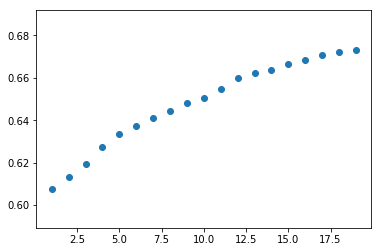

In [30]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_ng_df['vect'], axis =0), train_ng_df['subreddit'])
    score = sklearn.metrics.accuracy_score(test_ng_df['subreddit'], tree2.predict(np.stack(test_ng_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

bag.fit(np.stack(train_ng_df['vect'], axis =0), train_ng_df['subreddit']) #Fit the bagged classifier

In [ ]:
df_backup = pd.HDFStore('reddit_sub_tokenized.h5')

df_backup['red_submissions_toks'] = reddit_submissions_min

df_backup.close()